# Date Differences and Windows

In [1]:
from pyspark.sql import SparkSession
from more_pyspark import to_pandas

spark = SparkSession.builder.appName('Ops').getOrCreate()

22/11/02 20:42:07 WARN Utils: Your hostname, nn1448lr222 resolves to a loopback address: 127.0.1.1; using 172.22.165.244 instead (on interface eth0)
22/11/02 20:42:07 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/11/02 20:42:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/11/02 20:42:10 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/11/02 20:42:10 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


## Example Data

#### Example 1 - Uber data

In [2]:
from uber_schema import uber_schema, uber_datetime_format

uber_april = spark.read.csv('./data/uber-raw-data-apr14-sample.csv', 
                            header=True, 
                            schema=uber_schema,
                            timestampFormat=uber_datetime_format
                           )

uber_april.take(5) >> to_pandas

,Date/Time,Lat,Lon,Base
0,2014-04-18 21:38:00,40.7359,-73.9852,B02682
1,2014-04-23 15:19:00,40.7642,-73.9543,B02598
2,2014-04-10 07:15:00,40.7138,-74.0103,B02598
3,2014-04-11 15:23:00,40.7847,-73.9698,B02682
4,2014-04-07 17:26:00,40.6460,-73.7767,B02598


#### Example 2 - MoMA exhibitions

In [3]:
from MoMA_schema import exhib_schema, exhib_date_format

exhibitions = spark.read.csv('./data/MoMAExhibitions1929to1989.csv', 
                             header=True, 
                             schema=exhib_schema,
                             encoding="ISO-8859-1",
                             dateFormat=exhib_date_format)
exhibitions.take(2) >> to_pandas # No more "bad" symbols

22/11/02 20:42:22 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,ExhibitionID,ExhibitionNumber,ExhibitionTitle,ExhibitionCitationDate,ExhibitionBeginDate,ExhibitionEndDate,ExhibitionSortOrder,ExhibitionURL,ExhibitionRole,ExhibitionRoleinPressRelease,...,Institution,Nationality,ConstituentBeginDate,ConstituentEndDate,ArtistBio,Gender,VIAFID,WikidataID,ULANID,ConstituentURL
0,2557,1,"Cézanne, Gauguin, Seurat, Van Gogh","[MoMA Exh. #1, November 7-December 7, 1929]",1929-11-07,1929-12-07,1,moma.org/calendar/exhibitions/1767,Curator,Director,...,None,American,1902,1981,"American, 19021981",Male,109252853,Q711362,500241556,moma.org/artists/9168
1,2557,1,"Cézanne, Gauguin, Seurat, Van Gogh","[MoMA Exh. #1, November 7-December 7, 1929]",1929-11-07,1929-12-07,1,moma.org/calendar/exhibitions/1767,Artist,Artist,...,None,French,1839,1906,"French, 18391906",Male,39374836,Q35548,500004793,moma.org/artists/1053


## Computing difference between dates

In addition to functions for extracting date- and time-parts, `pyspark` also included functions 

1. `datediff` is the difference in *days*
2. `monthsbetween` is the difference in *months*

In [14]:
from pyspark.sql.functions import datediff, months_between, count, col

length_of_exhib = (exhibitions
.select('ExhibitionBeginDate', 'ExhibitionEndDate')
.withColumn('Length in days', datediff('ExhibitionEndDate', 'ExhibitionBeginDate'))
.groupBy('Length in days')
.agg(count('Length in days').alias('Number of Exhibits'))
.collect()
) >> to_pandas

length_of_exhib

,Length in days,Number of Exhibits
0,31.0,234
1,137.0,158
2,65.0,55
3,53.0,739
4,108.0,67
...,...,...
196,214.0,8
197,123.0,20
198,420.0,33
199,180.0,1


<AxesSubplot:xlabel='Length in days', ylabel='Number of Exhibits'>

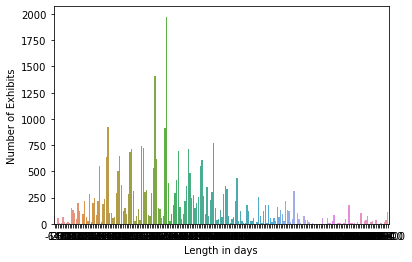

In [5]:
import seaborn as sns
import numpy as np

sns.barplot(x = 'Length in days', y = 'Number of Exhibits', data=length_of_exhib)

### Fixing the x-axis ticks

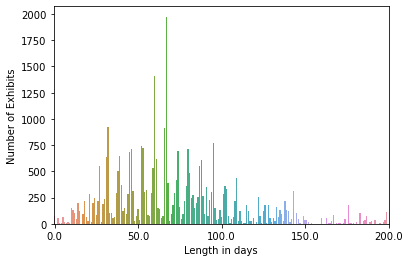

In [6]:
import seaborn as sns
import numpy as np

x_ticks = np.linspace(0,
                      200, # Took some experimentation to get this
                      5)

ax = sns.barplot(x = 'Length in days', y = 'Number of Exhibits', data=length_of_exhib)
_ = ax.set_xticks(x_ticks, x_ticks)

## <font color='red'> Exercise 6.4.3 - Exhibition Length in Months </font>

Create a visualization of the length of the exhibitions in months.

In [30]:
# Your code here

import pyspark.sql.functions as F

length_of_exhib_months = ((exhibitions
                            .select('ExhibitionBeginDate', 'ExhibitionEndDate')
                            .withColumn('Length_in_months', F.round(datediff('ExhibitionEndDate', 'ExhibitionBeginDate') / 30.417))
                            .groupBy('Length_in_months')
                            .agg(count('Length_in_months').alias('Number_of_Exhibits'))
                            .collect()
                          ) >> to_pandas )
length_of_exhib_months

,Length_in_months,Number_of_Exhibits
0,8.0,220
1,0.0,903
2,7.0,176
3,98.0,113
4,NaN,0
5,1.0,6936
6,4.0,2345
7,14.0,35
8,22.0,2
9,3.0,7776


## <font color="blue"> Key </font>

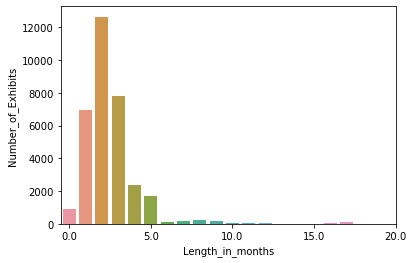

In [69]:
# Answer here
x_ticks = np.linspace(0,
                      20, # Took some experimentation to get this
                      5)

ax = sns.barplot(x = 'Length_in_months', y = 'Number_of_Exhibits', data=length_of_exhib_months)
_ = ax.set_xticks(x_ticks, x_ticks)

## Time Windows

We can use the `window` function to group and aggregate by various time windows.

### Example - Uber by week

In [70]:
from pyspark.sql.functions import window

daily_rides = (uber_april
                .groupBy(window('Date/Time', '1 day'))
                .agg(count('Date/Time').alias('Number of Rides'))
                .collect()
                ) >> to_pandas

daily_rides

,window,Number of Rides
0,"(2014-04-21 19:00:00, 2014-04-22 19:00:00)",2762
1,"(2014-04-03 19:00:00, 2014-04-04 19:00:00)",4429
2,"(2014-03-31 19:00:00, 2014-04-01 19:00:00)",1997
3,"(2014-04-09 19:00:00, 2014-04-10 19:00:00)",3364
4,"(2014-04-01 19:00:00, 2014-04-02 19:00:00)",2913
5,"(2014-04-07 19:00:00, 2014-04-08 19:00:00)",3095
6,"(2014-04-05 19:00:00, 2014-04-06 19:00:00)",3294
7,"(2014-04-10 19:00:00, 2014-04-11 19:00:00)",3664
8,"(2014-04-02 19:00:00, 2014-04-03 19:00:00)",3166
9,"(2014-04-17 19:00:00, 2014-04-18 19:00:00)",3313


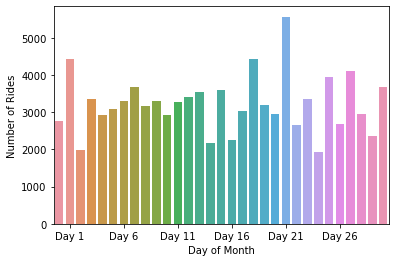

In [71]:
x_ticks = range(1, 31, 5)
x_labels = ['Day {0}'.format(i) for i in range(1, 31, 5)]

ax = sns.barplot(x = 'window', y = 'Number of Rides', data = daily_rides)
_ = ax.set_xticks(x_ticks, x_labels)
_ = ax.set_xlabel('Day of Month')

## <font color='red'> Exercise 6.4.4 - Uber rides per hour </font>

Create a line plot to visualize the number of rides across all hourly windows.

In [173]:
#Group By Hours across month
hourly_rides_across_month = (uber_april
                                .groupBy(window('Date/Time', '1 hour'))
                                .agg(count('Date/Time').alias('Number of Rides'))
                                .sort('window')
                                .collect()
                                ) >> to_pandas

hourly_rides_across_month

,window,Number of Rides
0,"(2014-04-01 00:00:00, 2014-04-01 01:00:00)",26
1,"(2014-04-01 01:00:00, 2014-04-01 02:00:00)",12
2,"(2014-04-01 02:00:00, 2014-04-01 03:00:00)",7
3,"(2014-04-01 03:00:00, 2014-04-01 04:00:00)",20
4,"(2014-04-01 04:00:00, 2014-04-01 05:00:00)",33
...,...,...
715,"(2014-04-30 19:00:00, 2014-04-30 20:00:00)",485
716,"(2014-04-30 20:00:00, 2014-04-30 21:00:00)",531
717,"(2014-04-30 21:00:00, 2014-04-30 22:00:00)",413
718,"(2014-04-30 22:00:00, 2014-04-30 23:00:00)",335


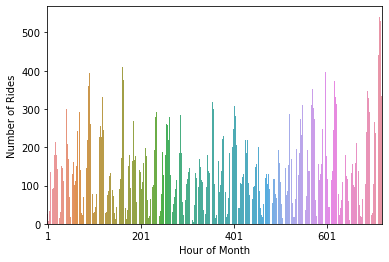

In [175]:
x_ticks = range(1, 720, 200)

ax = sns.barplot(x = 'window', y = 'Number of Rides', data = hourly_rides_across_month)
_ = ax.set_xticks(x_ticks, x_ticks)
_ = ax.set_xlabel('Hour of Month')

In [178]:
# Group By Hours

from pyspark.sql.functions import substring
hourly_rides = (uber_april
                .groupBy(window('Date/Time', '1 hour'))
                .agg(count('Date/Time').alias('Number of Rides'))
                .sort('window')
                .withColumn('window2',col('window').astype('String'))
                .withColumn('hour', substring(col('window2'),-9,2))
                .drop(col('window2'))
                .collect()
                ) >> to_pandas

hourly_rides

,window,Number of Rides,hour
0,"(2014-04-01 00:00:00, 2014-04-01 01:00:00)",26,01
1,"(2014-04-01 01:00:00, 2014-04-01 02:00:00)",12,02
2,"(2014-04-01 02:00:00, 2014-04-01 03:00:00)",7,03
3,"(2014-04-01 03:00:00, 2014-04-01 04:00:00)",20,04
4,"(2014-04-01 04:00:00, 2014-04-01 05:00:00)",33,05
...,...,...,...
715,"(2014-04-30 19:00:00, 2014-04-30 20:00:00)",485,20
716,"(2014-04-30 20:00:00, 2014-04-30 21:00:00)",531,21
717,"(2014-04-30 21:00:00, 2014-04-30 22:00:00)",413,22
718,"(2014-04-30 22:00:00, 2014-04-30 23:00:00)",335,23


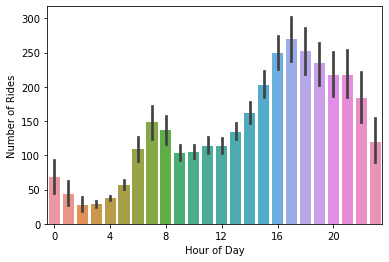

In [179]:
x_ticks = range(0, 24, 4)
x_labels = ['Hour {0}'.format(i) for i in range(1, 720, 200)]

ax = sns.barplot(x = 'hour', y = 'Number of Rides', data = hourly_rides)
_ = ax.set_xticks(x_ticks, x_ticks)
_ = ax.set_xlabel('Hour of Day')

## Other time functions

* Get the `current_date` or `current_time`
* Get the `next_day`
* Round dates/times with `trunc`/`date_trunc`
* Add/subtract days or with `dateadd`/`datesub`/`month_add`